<a href="https://colab.research.google.com/github/dikoharyadhanto/Project-Lomba/blob/time-series-prediction/Covid_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [430]:
import numpy as np
import pandas as pd
import requests
from fbprophet import Prophet
import matplotlib.pyplot as plt

# **Data 2: Data Kasus Covid (Webscraping)**

covid19.go.id menyediakan data kasus COVID-19 tingkat provinsi di alamat API yang berbeda. Sebagai data mengenai COVID-19 Jakarta, tersedia di https://data.covid19.go.id/public/api/prov_detail_DKI_JAKARTA.json.

In [431]:
url = 'https://data.covid19.go.id/public/api/prov_detail_DKI_JAKARTA.json'
resp_dki = requests.get(url)
cov_dki_raw = resp_dki.json()
print (resp_dki)

<Response [200]>


## **Akses Data Covid dengan API**

In [432]:
print('Nama-nama elemen utama:\n', cov_dki_raw.keys())

Nama-nama elemen utama:
 dict_keys(['last_date', 'provinsi', 'kasus_total', 'kasus_tanpa_tgl', 'kasus_dengan_tgl', 'meninggal_persen', 'meninggal_tanpa_tgl', 'meninggal_dengan_tgl', 'sembuh_persen', 'sembuh_tanpa_tgl', 'sembuh_dengan_tgl', 'list_perkembangan', 'data'])


### **Berapa jumlah total kasus COVID-19 di DKI Jakarta?**

In [433]:
print('\nJumlah total kasus COVID-19 di DKI Jakarta : %d' %cov_dki_raw['kasus_total'])


Jumlah total kasus COVID-19 di DKI Jakarta : 859203


### **Berapa persentase kematian akibat COVID-19 di DKI Jakarta?**

In [434]:
print('Persentase kematian akibat COVID-19 di DKI Jakarta : %f.2%%' %cov_dki_raw['meninggal_persen'])

Persentase kematian akibat COVID-19 di DKI Jakarta : 1.578789.2%


### **Berapa persentase tingkat kesembuhan dari COVID-19 di DKI Jakarta?**

In [435]:
print('Persentase tingkat kesembuhan dari COVID-19 di DKI Jakarta : %f.2%%' %cov_dki_raw['sembuh_persen'])

Persentase tingkat kesembuhan dari COVID-19 di DKI Jakarta : 98.237669.2%


Kita dapat mengakses data perkembangan COVID-19 dari waktu ke waktu yang juga disediakan oleh covid19.go.id melalui permintaan API yang telah Anda buat sebelumnya. Data historis perkembangan COVID-19 tersebut tersimpan dengan nama `list_perkembangan`.

In [436]:
cov_dki = pd.DataFrame(cov_dki_raw['list_perkembangan'])
print('Info cov_dki:\n', cov_dki.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   tanggal                       590 non-null    int64
 1   KASUS                         590 non-null    int64
 2   MENINGGAL                     590 non-null    int64
 3   SEMBUH                        590 non-null    int64
 4   DIRAWAT_OR_ISOLASI            590 non-null    int64
 5   AKUMULASI_KASUS               590 non-null    int64
 6   AKUMULASI_SEMBUH              590 non-null    int64
 7   AKUMULASI_MENINGGAL           590 non-null    int64
 8   AKUMULASI_DIRAWAT_OR_ISOLASI  590 non-null    int64
dtypes: int64(9)
memory usage: 41.6 KB
Info cov_dki:
 None


In [437]:
cov_dki.head()

,tanggal,KASUS,MENINGGAL,SEMBUH,DIRAWAT_OR_ISOLASI,AKUMULASI_KASUS,AKUMULASI_SEMBUH,AKUMULASI_MENINGGAL,AKUMULASI_DIRAWAT_OR_ISOLASI
0,1583020800000,2,0,0,2,2,0,0,2
1,1583107200000,2,0,0,2,4,0,0,4
2,1583193600000,2,0,0,2,6,0,0,6
3,1583280000000,2,0,0,2,8,0,0,8
4,1583366400000,0,1,0,-1,8,0,1,7


## **Data Preprocessing**

- Menghapus kolom `DIRAWAT_OR_ISOLASI` dan semua kolom yang berisi nilai kumulatif
- Merubah format penulisan semua kolom menjadi huruf kecil
- Mengganti nama kolom `kasus` menjadi `kasus_baru`
- Memperbaiki tipe data pada kolom tanggal menggunakan `pd.to_datetime`

In [438]:
cov_dki_tidy = (cov_dki.drop(columns=[item for item in cov_dki.columns 
                                               if item.startswith('AKUMULASI') 
                                                  or item.startswith('DIRAWAT')])
                           .rename(columns=str.lower)
                           .rename(columns={'kasus': 'kasus_baru'})
                  )
cov_dki_tidy['tanggal'] = pd.to_datetime(cov_dki_tidy['tanggal']*1e6, unit='ns')
print('Lima data teratas:\n', cov_dki_tidy.head())
print('\nLima data terakhir:\n', cov_dki_tidy.tail())

Lima data teratas:
      tanggal  kasus_baru  meninggal  sembuh
0 2020-03-01           2          0       0
1 2020-03-02           2          0       0
2 2020-03-03           2          0       0
3 2020-03-04           2          0       0
4 2020-03-05           0          1       0

Lima data terakhir:
        tanggal  kasus_baru  meninggal  sembuh
585 2021-10-07         150          1     100
586 2021-10-08         150          0     309
587 2021-10-09         100          2       0
588 2021-10-10         140          3      69
589 2021-10-11          41          0     200


# **Data Preprocessing**

In [439]:
cov_dki_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tanggal     590 non-null    datetime64[ns]
 1   kasus_baru  590 non-null    int64         
 2   meninggal   590 non-null    int64         
 3   sembuh      590 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 18.6 KB


In [440]:
#Checking Missing Values
cov_dki_tidy.isnull().sum()

tanggal       0
kasus_baru    0
meninggal     0
sembuh        0
dtype: int64

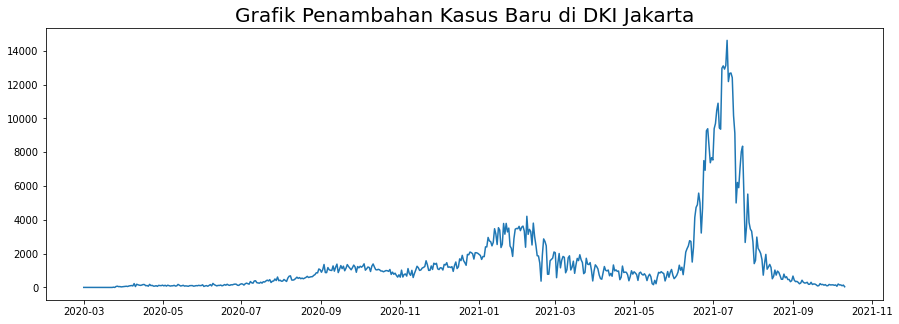

In [441]:
#Plotting dataset 'Open' and dates
plt.figure(figsize=(15,5))
plt.plot(cov_dki_tidy['tanggal'], cov_dki_tidy['kasus_baru'])
plt.title('Grafik Penambahan Kasus Baru di DKI Jakarta', fontsize=20);

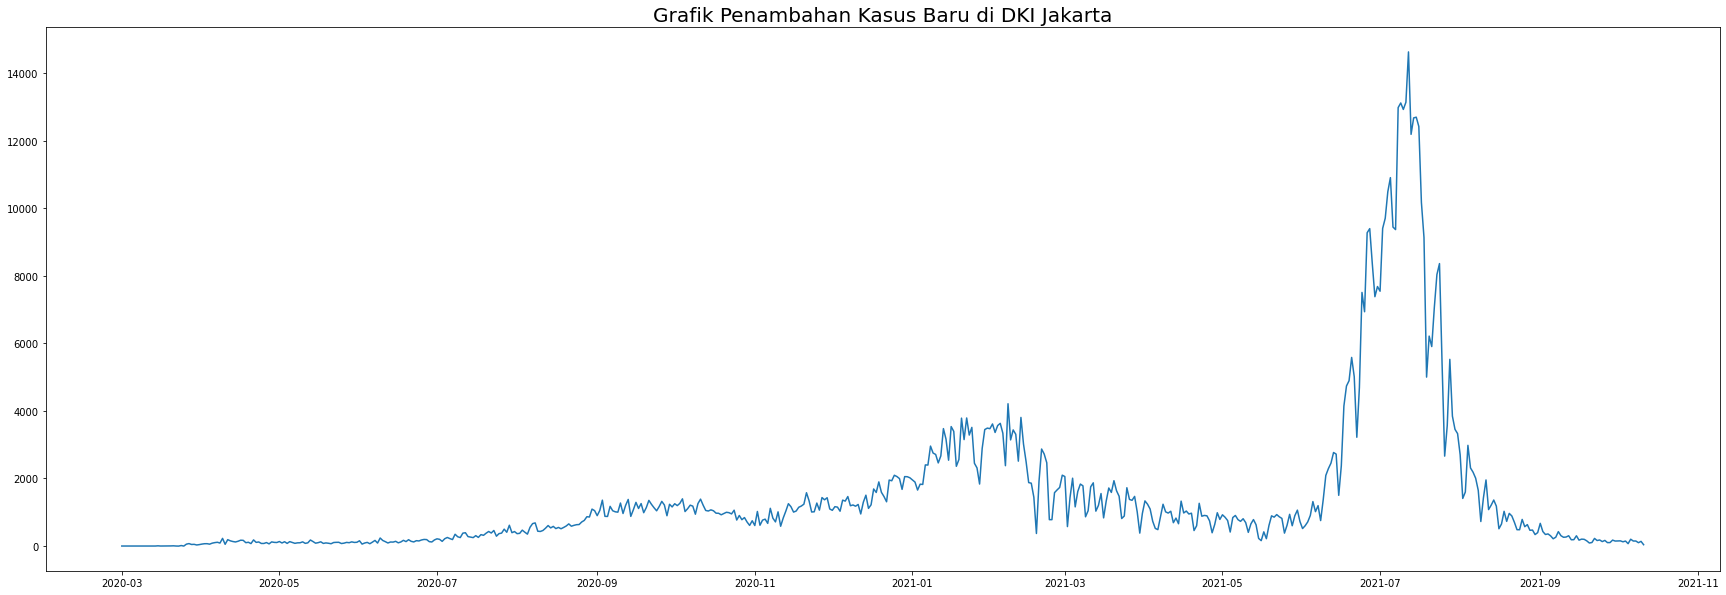

In [442]:
tanggal = cov_dki_tidy['tanggal'].values
kasus  = cov_dki_tidy['kasus_baru'].values
kasus = [float(i) for i in kasus]

#Plotting dataset 'kasus_baru' and 'tanggal'
plt.figure(figsize=(30,10))
plt.plot(tanggal, kasus)
plt.title('Grafik Penambahan Kasus Baru di DKI Jakarta', fontsize=20);

# **Modelling**

In [443]:
df = cov_dki_tidy[['tanggal', 'kasus_baru']]
df

,tanggal,kasus_baru
0,2020-03-01,2
1,2020-03-02,2
2,2020-03-03,2
3,2020-03-04,2
4,2020-03-05,0
...,...,...
585,2021-10-07,150
586,2021-10-08,150
587,2021-10-09,100
588,2021-10-10,140


In [444]:
df.columns = ['ds', 'y']
df

,ds,y
0,2020-03-01,2
1,2020-03-02,2
2,2020-03-03,2
3,2020-03-04,2
4,2020-03-05,0
...,...,...
585,2021-10-07,150
586,2021-10-08,150
587,2021-10-09,100
588,2021-10-10,140


In [445]:
#Python
df.loc[(df['y'] > 5000), 'y'] = None

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [446]:
model = Prophet()

In [447]:
#model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [448]:
future_dates = model.make_future_dataframe(periods = 180)
future_dates.tail()

,ds
765,2022-04-05
766,2022-04-06
767,2022-04-07
768,2022-04-08
769,2022-04-09


In [449]:
prediction = model.predict(future_dates)

In [450]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-01,-283.506887,-1158.260081,611.679533,-283.506887,-283.506887,31.150523,31.150523,31.150523,31.150523,31.150523,31.150523,0.0,0.0,0.0,-252.356364
1,2020-03-02,-277.528311,-1144.023842,599.067873,-277.528311,-277.528311,-42.476421,-42.476421,-42.476421,-42.476421,-42.476421,-42.476421,0.0,0.0,0.0,-320.004732
2,2020-03-03,-271.549734,-1402.257459,413.524850,-271.549734,-271.549734,-158.644464,-158.644464,-158.644464,-158.644464,-158.644464,-158.644464,0.0,0.0,0.0,-430.194198
3,2020-03-04,-265.571158,-1223.693304,672.616925,-265.571158,-265.571158,-13.132148,-13.132148,-13.132148,-13.132148,-13.132148,-13.132148,0.0,0.0,0.0,-278.703305
4,2020-03-05,-259.592581,-1096.460541,681.001512,-259.592581,-259.592581,50.000917,50.000917,50.000917,50.000917,50.000917,50.000917,0.0,0.0,0.0,-209.591664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,2022-04-05,-297.380619,-1463.886848,472.501747,-542.349465,-25.299535,-158.644464,-158.644464,-158.644464,-158.644464,-158.644464,-158.644464,0.0,0.0,0.0,-456.025083
766,2022-04-06,-302.493220,-1271.093573,602.857756,-549.943297,-29.585444,-13.132148,-13.132148,-13.132148,-13.132148,-13.132148,-13.132148,0.0,0.0,0.0,-315.625367
767,2022-04-07,-307.605821,-1181.919820,605.573559,-557.317957,-31.870701,50.000917,50.000917,50.000917,50.000917,50.000917,50.000917,0.0,0.0,0.0,-257.604904
768,2022-04-08,-312.718422,-1192.084020,718.173381,-564.574165,-33.999847,54.835005,54.835005,54.835005,54.835005,54.835005,54.835005,0.0,0.0,0.0,-257.883417


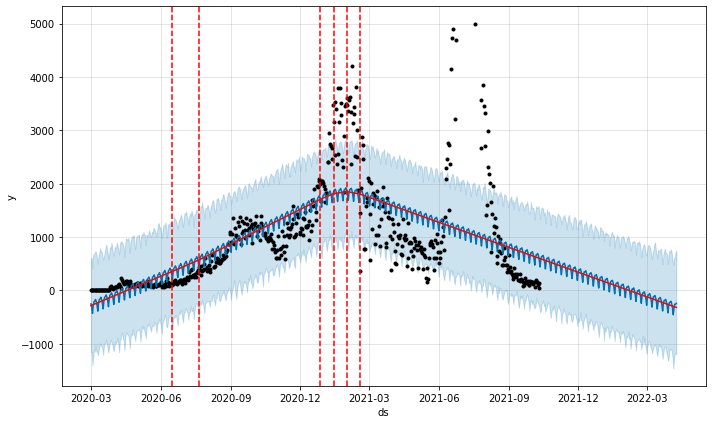

In [451]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(prediction)
a = add_changepoints_to_plot(fig.gca(), model, prediction)

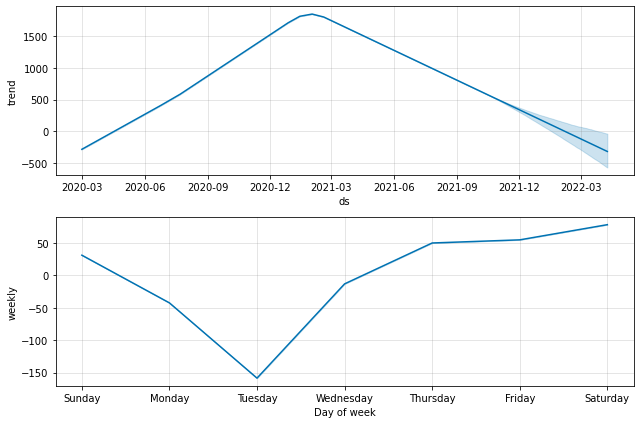

In [452]:
model.plot_components(prediction)
plt.show()

In [458]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='1 days', period='14 days', horizon = '7 days')
df_cv

INFO:fbprophet:Making 41 forecasts with cutoffs between 2020-03-11 00:00:00 and 2021-10-04 00:00:00


  0%|          | 0/41 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-12,-2.000000,-2.000000,-2.000000,2.0,2020-03-11
1,2020-03-13,-2.000000,-2.000000,-2.000000,4.0,2020-03-11
2,2020-03-14,-2.000000,-2.000000,-2.000000,2.0,2020-03-11
3,2020-03-15,-2.000000,-2.000000,-2.000000,8.0,2020-03-11
4,2020-03-16,-2.000000,-2.000000,-2.000000,2.0,2020-03-11
...,...,...,...,...,...,...
273,2021-10-07,716.765462,-206.070093,1647.463300,150.0,2021-10-04
274,2021-10-08,717.617091,-98.385271,1532.406869,150.0,2021-10-04
275,2021-10-09,737.474993,-141.779309,1672.016824,100.0,2021-10-04
276,2021-10-10,681.637436,-205.879164,1592.218344,140.0,2021-10-04


In [459]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
2,3 days,9.275536e+05,963.095848,560.394593,0.731625,0.344683,0.325000
3,4 days,4.207957e+05,648.687649,440.967875,0.685845,0.336408,0.384615
4,5 days,4.417873e+05,664.670799,452.228451,0.916373,0.436924,0.282051
5,6 days,7.280463e+05,853.256312,511.318869,0.957098,0.472332,0.450000
6,7 days,1.330121e+06,1153.308681,696.948145,1.265125,0.445786,0.268293


In [460]:
minMAE = (df['y'].max() - df['y'].min()) * (10/100)
minMAE

500.0

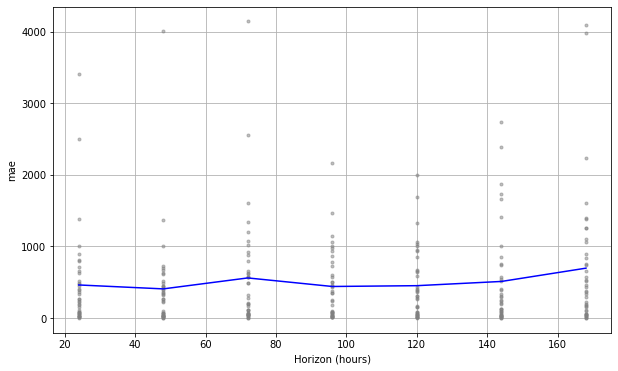

In [461]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [462]:
print('Average MAE value : ', df_p['mae'].mean()/(df['y'].max() - df['y'].min())*100)
print('Model Accuration Based on MAE : ', 100 - (df_p['mae'].mean())/(df['y'].max() - df['y'].min())*100)

Average MAE value :  10.090133429509649
Model Accuration Based on MAE :  89.90986657049035
